In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

Import Train Data

In [ ]:
# Import
root_path = "C:/QRT 2025 Reconstruction of Liquid Asset Performance/Data"

x_train_path = root_path + "/X_train_itDkypA.csv"
y_train_path = root_path + "/y_train_3LeeT2g.csv"

x_train = pd.read_csv(x_train_path)
y_train = pd.read_csv(y_train_path)

x_train.fillna(0, inplace=True)
y_train.fillna(0, inplace=True)

,ID,RET_TARGET
0,0,-0.022351
1,1,-0.011892
2,2,-0.015285
3,3,-0.019226
4,4,0.006644
...,...,...
267095,267095,0.002080
267096,267096,-0.002565
267097,267097,-0.018406
267098,267098,0.045101


In [3]:
# Consolidate Data in to a single DataFrame : All_data
All_data = x_train.copy()
All_data['RET_TARGET'] = y_train['RET_TARGET']

All_data = All_data[All_data['ID_TARGET']==292]

# List all columns in All_data
All_data_columns = All_data.columns.tolist()
#print("All_data columns:", All_data_columns)

# Obtain the unique values of the 'ID_TARGET' column
unique_ids = All_data['ID_TARGET'].unique().tolist()
unique_ids.sort() # Sort the unique IDs for better readability
print("Unique IDs in All_data:", unique_ids,'\n',len(unique_ids)," unique IDs found.")

print(len(All_data))

Unique IDs in All_data: [292] 
 1  unique IDs found.
2710


Function filter_data

In [4]:
def filtered_data(i,All_data = All_data, print_rows = False):
    """Filter the DataFrame by a specific ID_TARGET."""
    filtered_data = All_data[All_data['ID_TARGET'] == i]
    if filtered_data.empty:
        print("No data found for ID_TARGET:", i)
        return None
    else:
        if print_rows: 
            print("ID_TARGET :",str(i),"with rows",len(filtered_data))
        return All_data[All_data['ID_TARGET'] == i]
    
# filtered_data(34)  # Example usage of the function

Data Manipulation

In [5]:
def columns_selection_loop(abs_data_set_sorted,train_data_x ,min_corr_x_to_y=0.25, max_corr_x_to_x=0.35, print_adopted_columns=False):
    """Select columns based on correlation threshold."""
    adopted_columns = []
    adopted_columns.append(abs_data_set_sorted.head(1).index[0])  # Add the highest abs correlated column

    for i in range(1, len(abs_data_set_sorted)):
        approval = True
        if abs_data_set_sorted.iloc[i] > min_corr_x_to_y and abs_data_set_sorted.index[i] not in adopted_columns:
            for j in range(len(adopted_columns)):
                if train_data_x[adopted_columns[j]].corr(train_data_x[abs_data_set_sorted.index[i]]) > max_corr_x_to_x:
                    approval = False
                    break
            if approval:
                adopted_columns.append(abs_data_set_sorted.index[i])
    if print_adopted_columns:                
        print("Adopted columns:", adopted_columns, "\nwith a total of", len(adopted_columns), "columns")
    return adopted_columns

def columns_selection(x_train,y_train, min_corr_x_to_y=0.25, max_corr_x_to_x=0.35):
    corr_x_to_y = x_train.corrwith(y_train)
    abs_corr_x_to_y = corr_x_to_y.abs()
    abs_corr_x_to_y_sorted = abs_corr_x_to_y.sort_values(ascending=False)
    return columns_selection_loop(abs_corr_x_to_y_sorted,x_train, min_corr_x_to_y, max_corr_x_to_x)

Multiple Linear Regression Model

In [6]:
# Multiple Linear Regression Model

def Multiple_linear_regression(x, y, print_summary=False):
    """
    Fit a linear regression model and return the model.
    
    Parameters:
    x (DataFrame): Feature matrix.
    y (Series): Target variable.
    
    Returns:
    LinearRegression: Fitted linear regression model and summary.
    """
    X = pd.DataFrame(x)  # Constuct X as a DataFrame of x
    y = pd.Series(y)  # Ensure y is a Series

    model = LinearRegression()
    model.fit(X, y)
    
    # Print the summary statistics using statsmodels
    if print_summary:    
        model_sm = sm.OLS(y, sm.add_constant(X)).fit()  # Fit the model using statsmodels
        print(model_sm.summary())

        # RSS and RSE
        RSS = lambda x: np.sum((y - model.predict(x)) ** 2)
        RSE = lambda x: np.sqrt(RSS(x) / (len(x) - 2))

        # Calculate RSS and RSE for the model
        rss_value = RSS(X)
        rse_value = RSE(X)

        print()
        print("RSS", rss_value,"RSE", rse_value)
    
    return model

def Multiple_linear_regression_vector(x,y,print_summary=False):
    """
    Fit a linear regression model and return the model.
    
    Parameters:
    x (DataFrame): Feature matrix.
    y (Series): Target variable.
    
    Returns:
    LinearRegression: Fitted linear regression model and summary.
    """
    X = pd.DataFrame(x)  # Constuct X as a DataFrame of x
    y = pd.Series(y)  # Ensure y is a Series

    model = LinearRegression()
    model.fit(X, y)
    model_vector = [model.intercept_]
    for i in range(len(X.columns)):
        model_vector.append(model.coef_[i])
    
    # Print the summary statistics using statsmodels
    if print_summary:
        model_sm = sm.OLS(y, sm.add_constant(X)).fit()  # Fit the model using statsmodels
        print(model_sm.summary())
        
        # RSS and RSE
        RSS = lambda x: np.sum((y - model.predict(x)) ** 2)
        RSE = lambda x: np.sqrt(RSS(x) / (len(x) - 2))

        # Calculate RSS and RSE for the model
        rss_value = RSS(X)
        rse_value = RSE(X)

        print()
        print("RSS", rss_value,"RSE", rse_value)
    
    model_vector = np.array(model_vector)
    return model_vector

In [7]:
def Regression_model(i,All_data = All_data,min_corr_x_to_y=0.25, max_corr_x_to_x=0.35):
    train_data = filtered_data(i,All_data)
    train_data_x = train_data.drop(columns=['ID_TARGET', 'RET_TARGET'])
    train_data_y = train_data['RET_TARGET']
    selected_train_data_x = train_data_x[columns_selection(train_data_x, train_data_y, min_corr_x_to_y, max_corr_x_to_x)]
    return Multiple_linear_regression(selected_train_data_x, train_data_y)

def Regression_model_vector(i,All_data = All_data,min_corr_x_to_y=0.25, max_corr_x_to_x=0.35):
    train_data = filtered_data(i,All_data)
    train_data_x = train_data.drop(columns=['ID_TARGET', 'RET_TARGET'])
    train_data_y = train_data['RET_TARGET']
    selected_train_data_x = train_data_x[columns_selection(train_data_x, train_data_y, min_corr_x_to_y, max_corr_x_to_x)]
    return Multiple_linear_regression_vector(selected_train_data_x, train_data_y)

Backtesting with K-fold Cross Validation

In [8]:
def K_fold_cross_validation(K = 3,min_corr_x_to_y = 0.25,max_corr_x_to_x = 0.45):
    # K-fold Cross Validation

    All_data_extended = pd.concat([All_data,All_data],ignore_index=False)

    Abs_Res_K_fold_list = []
    for k in range(K):

        a = len(All_data)//K*k
        b = len(All_data)//K*(k+1)
        c = len(All_data)//K*(k+3)
        test_set = All_data_extended[a:b]  
        train_set = All_data_extended[b:c]
        test_set = pd.concat([test_set],ignore_index=True)

        if True:
            Regression_model_vector_dict = {str(i): Regression_model_vector(i,train_set,min_corr_x_to_y,max_corr_x_to_x) for i in unique_ids}
            Columns_selestion_dict = {str(i): columns_selection(filtered_data(i,train_set).drop(columns=['ID_TARGET', 'RET_TARGET']),\
                                        filtered_data(i,train_set)['RET_TARGET'],min_corr_x_to_y,max_corr_x_to_x) for i in unique_ids}

        x_test = test_set
        
        if True:
            y_test = pd.DataFrame()
            y_test['ID'] = x_test['ID']
            RET_TARGET_test=[]

            for i in range(len(x_test)):

                x_test_row = x_test.iloc[i]  # Select the first column as ID
                model_ID = str(int(x_test_row.loc['ID_TARGET']))  # Get the ID_TARGET value from the first row
                
                x_test_row_vector = [[1]]
                for ind in Columns_selestion_dict[model_ID]:
                    x_test_row_vector.append([x_test_row.loc[ind]])
                    
                x_test_row_vector = np.array(x_test_row_vector)
                
                Model_vector = Regression_model_vector_dict[model_ID].reshape(1,1+len(Columns_selestion_dict[model_ID]))

                result = float((Model_vector@x_test_row_vector)[0,0])
                
                RET_TARGET_test.append(result)

            y_test['RET_TARGET'] = pd.Series(RET_TARGET_test)
            y_test['Residuals'] = y_test['RET_TARGET']-x_test['RET_TARGET']
            y_test['Residuals_abs'] = abs(y_test['Residuals'])
            
            Abs_Res_K_fold_list.append(y_test['Residuals_abs'].sum()/(len(y_test['Residuals'])))

    return Abs_Res_K_fold_list

Optimal min_corr_x_to_y & max_corr_x_to_x

In [9]:
K= 3
min_corr_x_to_y_range = [0.01*i for i in range(101)]
validation_result_list = []
for x in min_corr_x_to_y_range:    
    validation_result_list.append(sum(K_fold_cross_validation(K,x))/K)

validation_result = pd.DataFrame()
validation_result['min_corr_x_to_y'] = pd.Series(min_corr_x_to_y_range)
validation_result['result'] = pd.Series(validation_result_list)

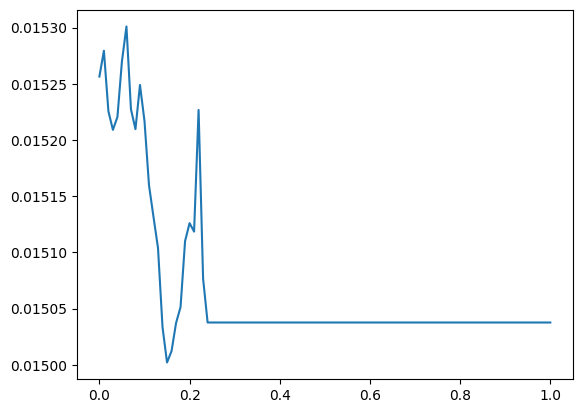

,min_corr_x_to_y,result
15,0.15,0.015002


In [10]:
plt.plot(validation_result['min_corr_x_to_y'],validation_result['result'])
plt.show()
optimal_min_corr_x_to_y  = float(validation_result[validation_result['result']==min(validation_result['result'])]['min_corr_x_to_y'].iloc[0])
validation_result[validation_result['result']==min(validation_result['result'])]

In [11]:
K= 3
max_corr_x_to_x_range = [0.01*i for i in range(100)]
validation_result_list = []
for x in max_corr_x_to_x_range:    
    validation_result_list.append(sum(K_fold_cross_validation(K,optimal_min_corr_x_to_y,x))/K)

validation_result = pd.DataFrame()
validation_result['max_corr_x_to_x'] = pd.Series(max_corr_x_to_x_range)
validation_result['result'] = pd.Series(validation_result_list)

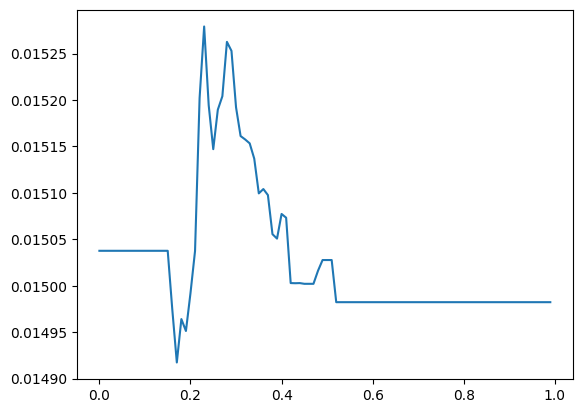

,max_corr_x_to_x,result
17,0.17,0.014917


In [12]:
plt.plot(validation_result['max_corr_x_to_x'],validation_result['result'])
plt.show()
validation_result[validation_result['result']==min(validation_result['result'])]